<a href="https://colab.research.google.com/github/4en1x/diploma/blob/master/Final6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cd /usr/src
!ln -sfn linux-headers-2.6.35-28-generic linux

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-fnmqvoq_
  Stored in directory: /tmp/pip-ephem-wheel-cache-f4qvqn7p/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [31]:
%%cu
#include <cuda_runtime.h>
#include "device_launch_parameters.h"
#include <stdlib.h>
#include <stdio.h>
#include <float.h>
#include "linux/kernel.h"
#include <iostream>
#include <ctime>
#include <iomanip>
#include <fstream>
#include <math.h>
#include <cmath>

using namespace std;

#define ITERATIONS 10000
#define N 256

#define e 2.7182818

#define blockZSize 2

#define blockXSize 64
#define blockYSize 64

#define tileXSize 2
#define tileYSize 2

#define extN (N + 2)
#define Dx 1
#define h ((float) Dx / (N + 1))
#define h2 powf(h, 2.0)

__device__
float f(int i, int j) {
	return 2 * powf(e, i * h + j * h);
}

float u_t(float x) {
	return powf(e, x);
}

float u_l(float x) {
	return powf(e, x);
}

float u_r(float x) {
	return powf(e, x + 1);
}

float u_d(float x) {
	return powf(e, x + 1);
}


__device__
void tile(float* matrix, int iGl, int jGl, bool isBlack) {
	int iBegin = iGl * blockXSize + threadIdx.x * tileXSize + 1;
	int jBegin = jGl * blockYSize + threadIdx.y * tileYSize + 1;

  int N1 = tileXSize + blockZSize * 2;
  int N2 = tileYSize + blockZSize * 2;
  
	float helper[6 * 6];

  for(int i = 0; i < N1; i++) {
		for(int j = 0; j < N2; j++) {
      int dAI = iBegin - blockZSize + i;
      int dAJ = jBegin - blockZSize + j;
      if(dAI < 0 || dAI >= extN || dAJ < 0 || dAJ >= extN) {
          helper[i * N1 + j] = FLT_MAX;
      }
      else {
          helper[i * N1 + j] = matrix[extN * dAI + dAJ];
      }
		}
	}
  
  int iSplit = iBegin - blockZSize;
  int jSplit = jBegin - blockZSize;
    
  for(int k = 1; k < blockZSize; k++) {
		for (int i = k; i < N1 - k; i++) {
		  for (int j = k; j < N2 - k; j += 1) {
        int b = N1 * i + j;
        if(helper[b + N1] != FLT_MAX && helper[b - N1] != FLT_MAX && helper[b + 1] != FLT_MAX && helper[b - 1] != FLT_MAX) {
            helper[b] = 0.25 * (
                helper[b + N1]
              + helper[b - N1]
              + helper[b + 1]
              + helper[b - 1] 
              - h2 * f(iSplit + i, jSplit + j)
            );
        }
		  }
	  }
	}

  //printf("iGl : %d, %d, %d, %d, %d, %d, %d \n", iGl, jGl, threadIdx.x, threadIdx.y, isBlack, iBegin, jBegin);
    
  for (int i = iBegin; i < iBegin + tileXSize; i++) {
		for (int j = jBegin; j < jBegin + tileYSize; j += 1) {
      int helperIndex = N1 * (i - iBegin + blockZSize) + j - jBegin + blockZSize;
			matrix[extN * i + j] = 0.25 * (
          helper[helperIndex + N1]
        + helper[helperIndex - N1]
        + helper[helperIndex + 1]
				+ helper[helperIndex - 1] 
        - h2 * f(i - blockZSize + 1, j - blockZSize + 1)
      );
      helper[helperIndex] =	matrix[extN * i + j];
		}
	}
    
}

__global__
void calculateBlack(float* matrix) {
	tile(matrix, blockIdx.x, blockIdx.y, true);
}

__global__
void calculateRed(float* matrix) {
	tile(matrix, blockIdx.x, blockIdx.y, false);
}

float func(int i, int j) {
	return powf(e, i * h + j * h);
}

float* createMatrix(int row, int col) {
	float* matrix = new float[row * col];

	for(int i = 0; i < row; i++) {
		for(int j = 0; j < col; j++) {
			matrix[i * row + j] = 0;
		}
	}

  for(int i = 0; i < row; i++) {
      matrix[0 * row + i] = u_t((i) * h);
      matrix[(row - 1) * row + i] = u_d((i) * h);
  }

  for(int j = 0; j < col; j++) {
      matrix[j * col + 0] = u_l((j) * h);
      matrix[j * col + row - 1] = u_r((j) * h);
	}
    
	return matrix;
}

float calculateDifference(float* matrix1) {
	float tolerance = 0.0f;

  for (int i = 1; i < extN - 1; i++) {
		for (int j = 1; j < extN - 1; j++) {
      float fCurrent = func(i, j);
      if(abs(matrix1[i * extN + j] - fCurrent) > tolerance) {
          tolerance = abs(matrix1[i * extN + j] - fCurrent);
      } 
		}
	}

	return tolerance;
}

int main() {
  float g = 0.0;
  for(int y=0; y < 5; y +=1) {
	float* matrixHost = createMatrix(extN, extN);
	float* matrixDevice;

	int matrixSize = sizeof(float) * extN * extN;

	cudaMalloc((void**)&matrixDevice, matrixSize);
	cudaMemcpy(matrixDevice, matrixHost, matrixSize, cudaMemcpyHostToDevice);

	long startTime = clock();
	dim3 blocks(N / blockXSize, N / blockYSize);
	dim3 threads(blockXSize / tileXSize, blockYSize / tileYSize);

	for (size_t i = 0; i < ITERATIONS; i++) {
		calculateBlack <<< blocks, threads >>>(matrixDevice);
		cudaDeviceSynchronize();
		cudaPeekAtLastError();

    if(i%100 == 0) {
        cudaMemcpy(matrixHost, matrixDevice, matrixSize, cudaMemcpyDeviceToHost);
        float diff = calculateDifference(matrixHost);
        if(diff < 0.01) break;
    }  
	}
  
	std::cout << "Calculation take time: " << clock() - startTime << std::endl;
  g += clock() - startTime;
  cout << " Difference: " << calculateDifference(matrixHost);
	cudaError_t cudaResult = cudaMemcpy(matrixHost, matrixDevice, matrixSize, cudaMemcpyDeviceToHost);

	if (cudaResult != cudaSuccess) {
		std::cout << "Cuda error: " << cudaResult << std::endl;
	}
  }
  cout << "      " << g / 5;
	return 0;
}

'Calculation take time: 2805183\n Difference: 0.556795Calculation take time: 2806384\n Difference: 0.556797Calculation take time: 2806255\n Difference: 0.556785Calculation take time: 2808330\n Difference: 0.556784Calculation take time: 2806362\n Difference: 0.556796      2.80654e+06'



128 4  8.555

128 8 6.64975

128 16 15.7738

64 2 6.44552

64 4 3.83954

64 8 4.95606

64 16 13.0364

32 2 4.2347

32 4 3.60903

32 8 4.55861

32 16 11.5468

16 2 3.65424

16 4 3.53603

16 8 7.73568

8 2 4.14145

8 4 5.19636




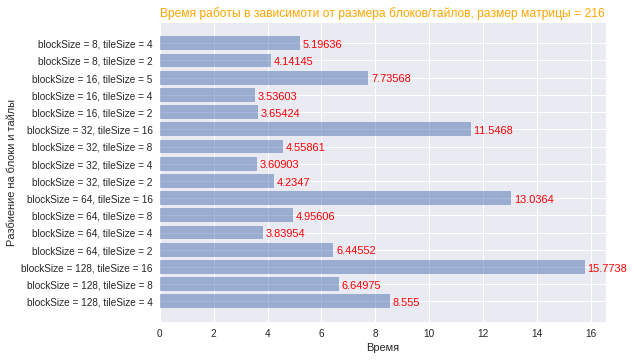

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

objects = (
    'blockSize = 128, tileSize = 4', 
    'blockSize = 128, tileSize = 8', 
    'blockSize = 128, tileSize = 16', 
    'blockSize = 64, tileSize = 2', 
    'blockSize = 64, tileSize = 4', 
    'blockSize = 64, tileSize = 8',
    'blockSize = 64, tileSize = 16',
    'blockSize = 32, tileSize = 2',
    'blockSize = 32, tileSize = 4',
    'blockSize = 32, tileSize = 8',
    'blockSize = 32, tileSize = 16',
    'blockSize = 16, tileSize = 2',
    'blockSize = 16, tileSize = 4',
    'blockSize = 16, tileSize = 5',
    'blockSize = 8, tileSize = 2',
    'blockSize = 8, tileSize = 4'
    
)
y_pos = np.arange(len(objects))
performance = [8.555,6.64975,15.7738, 6.44552, 3.83954, 4.95606, 13.0364, 4.2347, 3.60903, 4.55861, 11.5468, 3.65424, 3.53603, 7.73568, 4.14145, 5.19636]

plt.style.use('seaborn-darkgrid')
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.title("Время работы в зависимоти от размера блоков/тайлов, размер матрицы = 216", loc='left', fontsize=12, fontweight=0, color='orange')
plt.ylabel('Разбиение на блоки и тайлы')
plt.xlabel('Время')

for i, v in enumerate(performance):
    plt.text(performance[i] + 0.1, 
             i-.25,
              performance[i], 
              fontsize=11, 
              color='red')

plt.show()
